# RISEI

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

import datetime
import os
import numpy as np

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.training import train

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.cmap'] = 'viridis'

%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

## Setup

In [3]:
%%time

ROOT_DIR = '../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v2'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path, 
    ROOT_DIR, 
    split=(0.8, 0.15, 0.05), 
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 32
input_shape = (112, 112, 105, 1)
resize_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weights (see analysis notebook)
class_weight = {0: 0.8271604938271606, 1: 1.2641509433962266}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    one_hot=one_hot,
    class_weight=class_weight,
    normalization=normalization)
print('initializing val_seq...')
val_seq = MRISequence(
    val_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    one_hot=one_hot,
    class_weight=class_weight,
    normalization=normalization)
print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    one_hot=one_hot,
    normalization=normalization)

model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing val_seq...
initializing test_seq...
log_dir: ../../tmp/logs/20201213-185832
CPU times: user 2 ms, sys: 1.87 ms, total: 3.88 ms
Wall time: 4.19 ms


In [4]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([243/159, 159/243])

model_config = {
    'input_shape': input_shape,
    'class_names': class_names,
#     'l2_beta': 0.001,
    'l2_beta': 0.0005,
#     'l2_beta': None,
    'dropout': 0.10,
#     'dropout': None,
    'output_bias': initial_bias,
#     'output_bias': None,
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    'batch_norm': False,
    'is_complex': False, # a complex layer from the paper, max batch_size is 3
}

compile_config = {
    # default is 0.001
#     'learning_rate': 0.000075,
    'learning_rate': 0.00025,
    'decay_steps': 25,
    'decay_rate': 0.96,
#     'beta_1': 0.85,
    'beta_1': 0.90,
#     'beta_2': 0.990,
    'beta_2': 0.999,
}

train_config = {
    'tpu': False,
    'model_key': model_key,
#     'validation': 'val_test', # validation is val + test
    'epochs': 2,
    'patience': 150,
    'tensorboard_update_freq': 'epoch', 
    'mri_tensorboard_callback': False,
    'model_checkpoint_callback': 'save_best_only',
    'batch_size': 1,
#     'model_checkpoint_callback': False,
}

## Model

In [5]:
model = create_model(**model_config)
model, *_ = compile_model(model, **compile_config)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 112, 112, 105, 32) 896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 56, 56, 53, 32)    0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 53, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 56, 56, 53, 64)    55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 18, 18, 17, 64)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 17, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 18, 18, 17, 128)   2

In [6]:
load_checkpoint(model, DEFAULT_CHECKPOINT_DIRECTORY_LOCAL, '20201213-182225', 'cp-0002.ckpt')

loading checkpoint from ../../tmp/checkpoints/20201213-182225/cp-0002.ckpt...


## RISEI

In [23]:
import SimpleITK as sitk

import src.heatmaps as heatmaps
import src.data.plot_image as plot_image

from src.heatmaps.evaluation import EvaluationSequence, plot_evaluation

from src.risei import RISEI

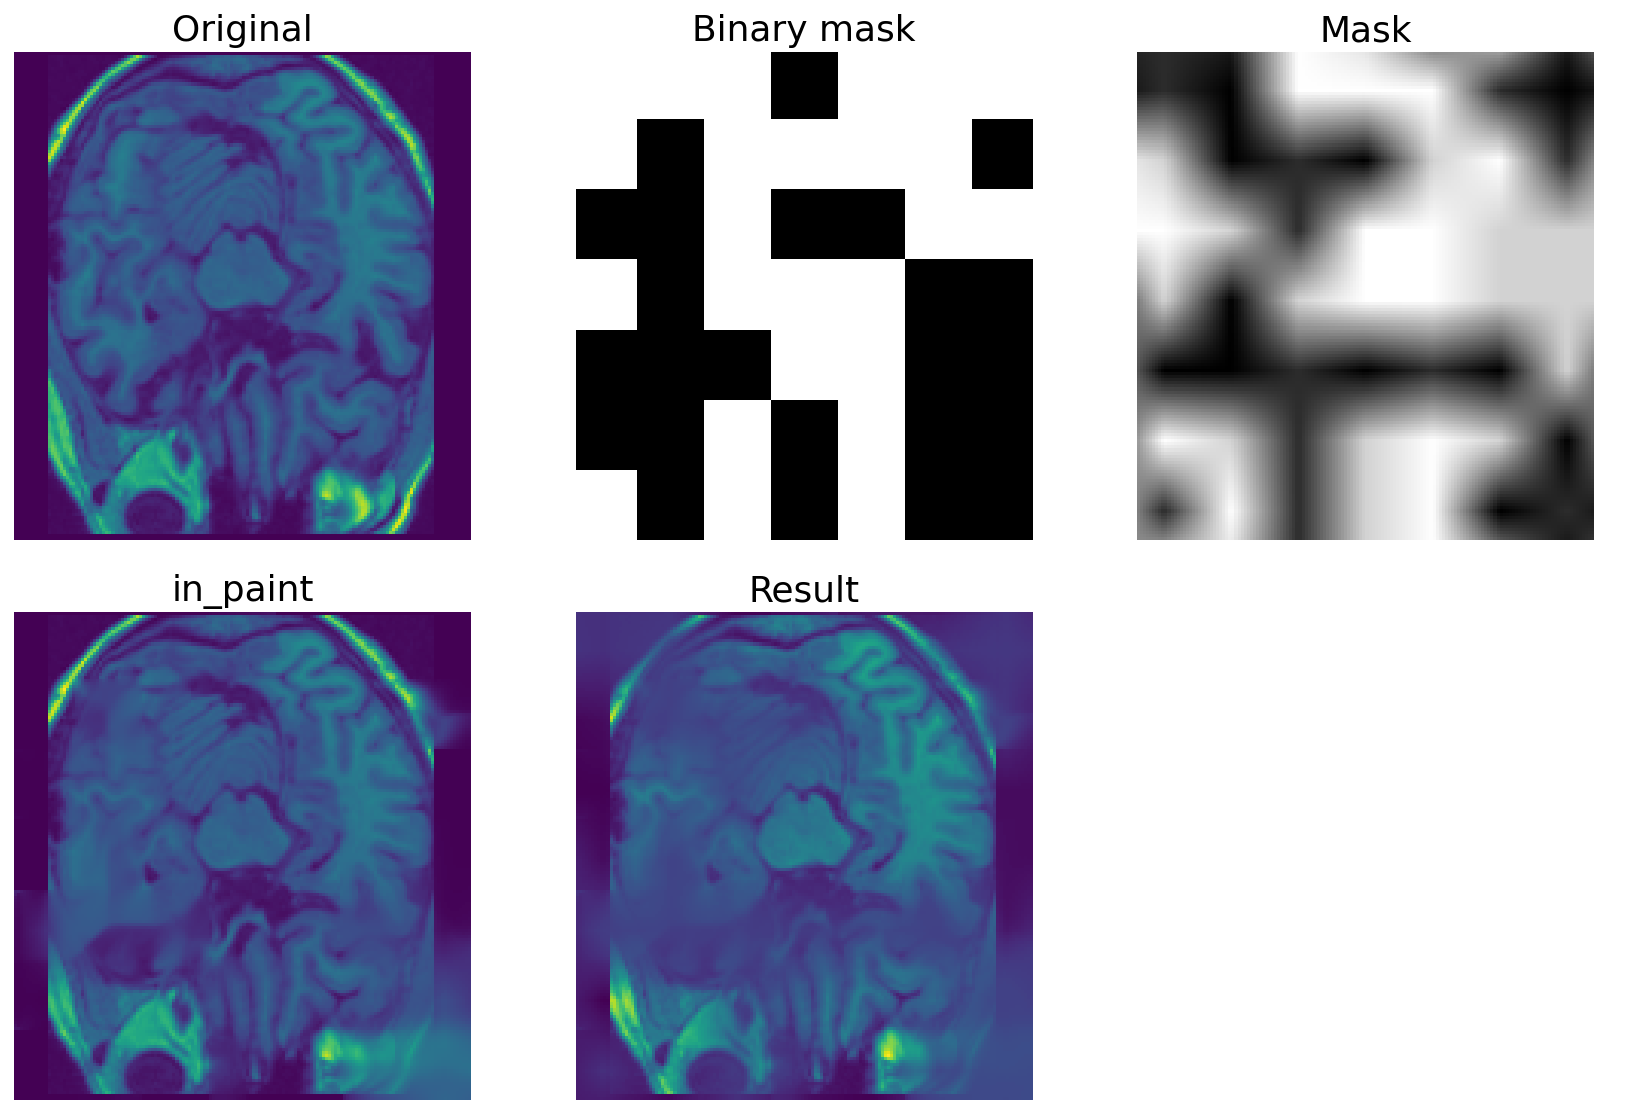

CPU times: user 25.8 s, sys: 407 ms, total: 26.2 s
Wall time: 26.2 s


In [8]:
%%time

raw_image = sitk.ReadImage(os.path.join(saliencies_and_segmentations_v2_path, '002_S_0729___2007-09-05___S38908/data.nii'))
image = sitk.GetArrayViewFromImage(raw_image)

risei = RISEI(image.shape, s=8, p1=0.5, b1=0.85, b2=0.9, inpaint='2d', inpaint_blending=True, inpaint_radius=5, processes=1, debug=True)

masks = risei.generate_masks(1, image, log=False)

risei.show_from_last_run(0, 60)

### Generate

In [9]:
image_x = None
image_y = None

batch_x, batch_y = test_seq[0]
print(batch_y)

idx = 1 # 5, 3
image_x = batch_x[idx]
image_y = batch_y[idx]

print(f'y_true: {np.argmax(image_y)}')
y_pred = model.predict(np.array([image_x]))
print(f'y_pred: {np.argmax(y_pred)}')
print(y_pred)

[[1. 0.]
 [1. 0.]]
y_true: 0
y_pred: 0
[[0.6813725  0.31862748]]


In [10]:
# Create a RISEI instance with a config.
# RISEI accepts shape without channels!
#
# p1 = probability of white place to be transparent
# b1 = inpaint mask blend (0 disables inpainting)
# b2 = black mask blend

processes = 4
debug = True

risei = RISEI(image_x.shape[:3], s=8, p1=1/4, b1=1, b2=0.75,
              inpaint="2d", inpaint_blending=True, inpaint_radius=5,
              processes=processes, debug=debug)

In [11]:
%%time

# get a heatmap for a prediciton
heatmap, masks_x, masks_y = heatmaps.get_heatmap(
    image_x,
    image_y,
    model,
    risei,
    batch_size=train_config['batch_size'],
    masks_count=10,
    risei_batch_size=480,
    debug=debug,
    log=False)


batch #0 of 1


y_true: 0
CPU times: user 21.7 s, sys: 2.38 s, total: 24.1 s
Wall time: 47.5 s


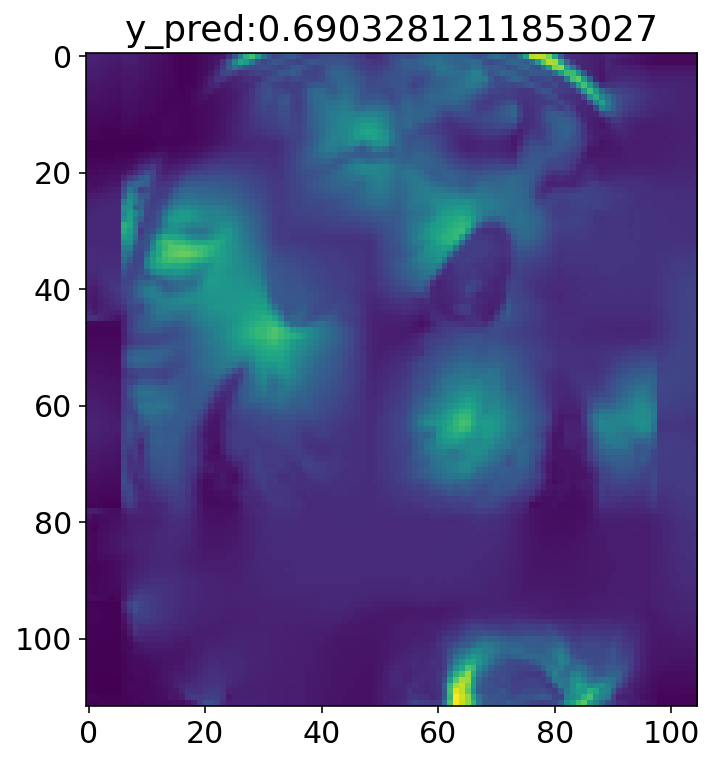

In [12]:
if debug:
    heatmaps.show_mask(0, masks_x, masks_y, 56)

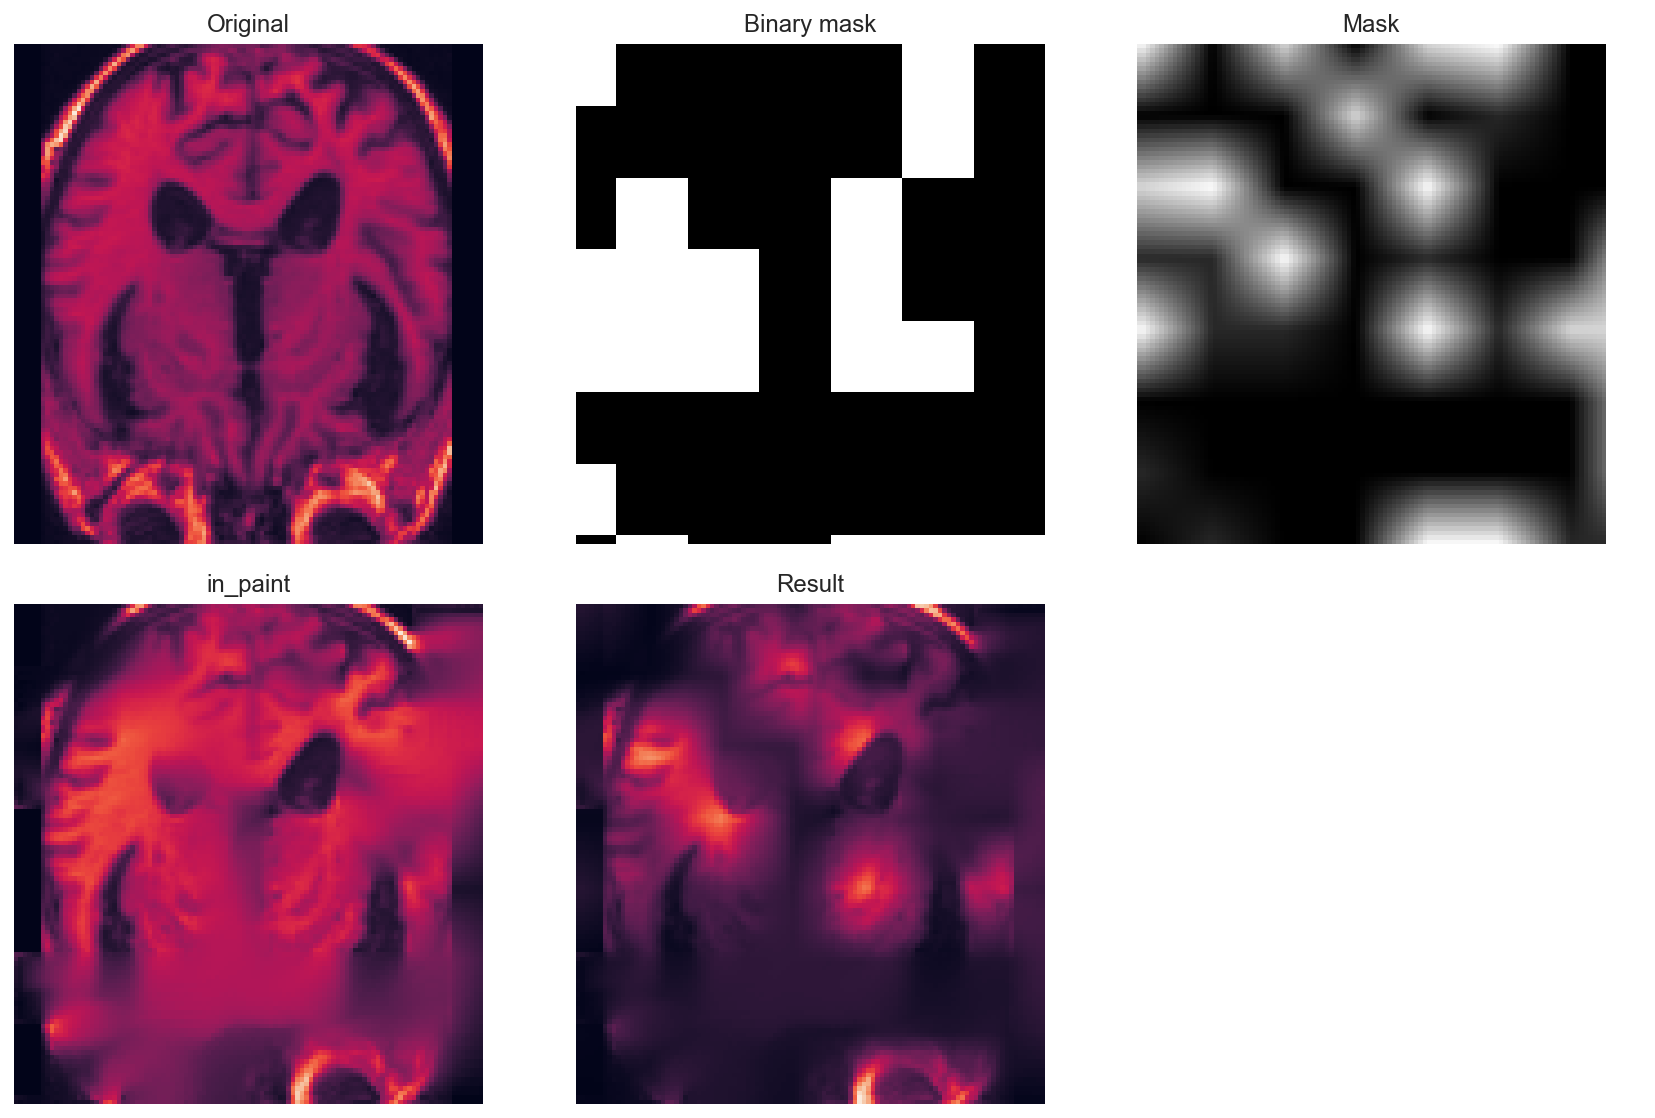

In [36]:
if debug:
    risei.show_from_last_run(0, 56)

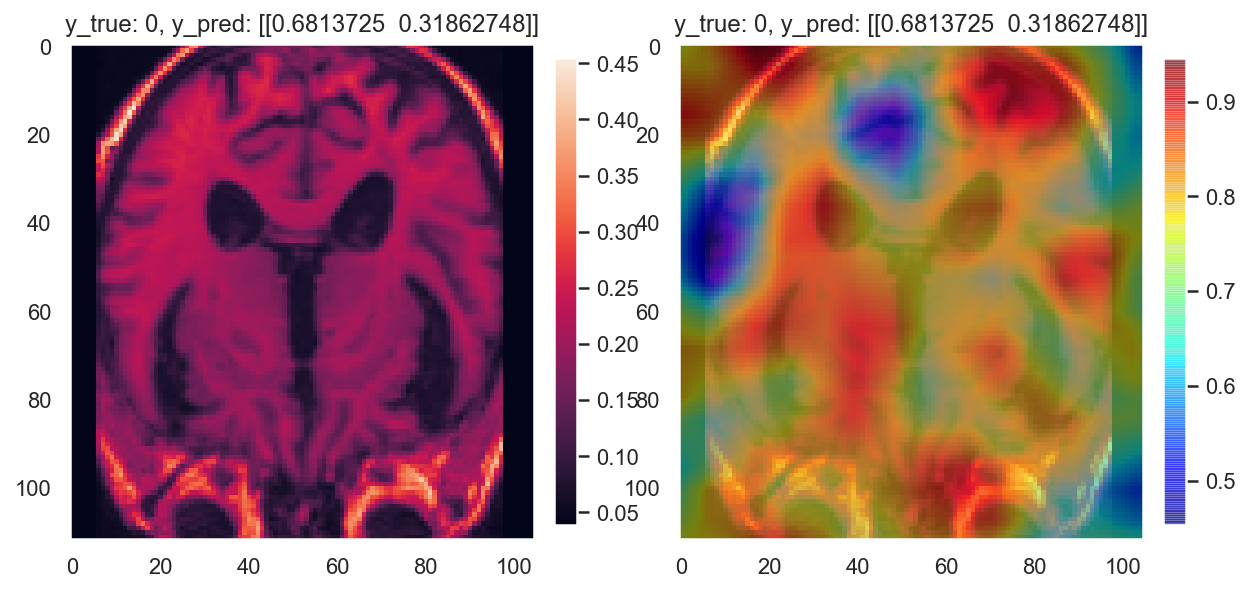

In [30]:
heatmaps.plot_heatmap_z(image_x, image_y, y_pred, heatmap, 56)

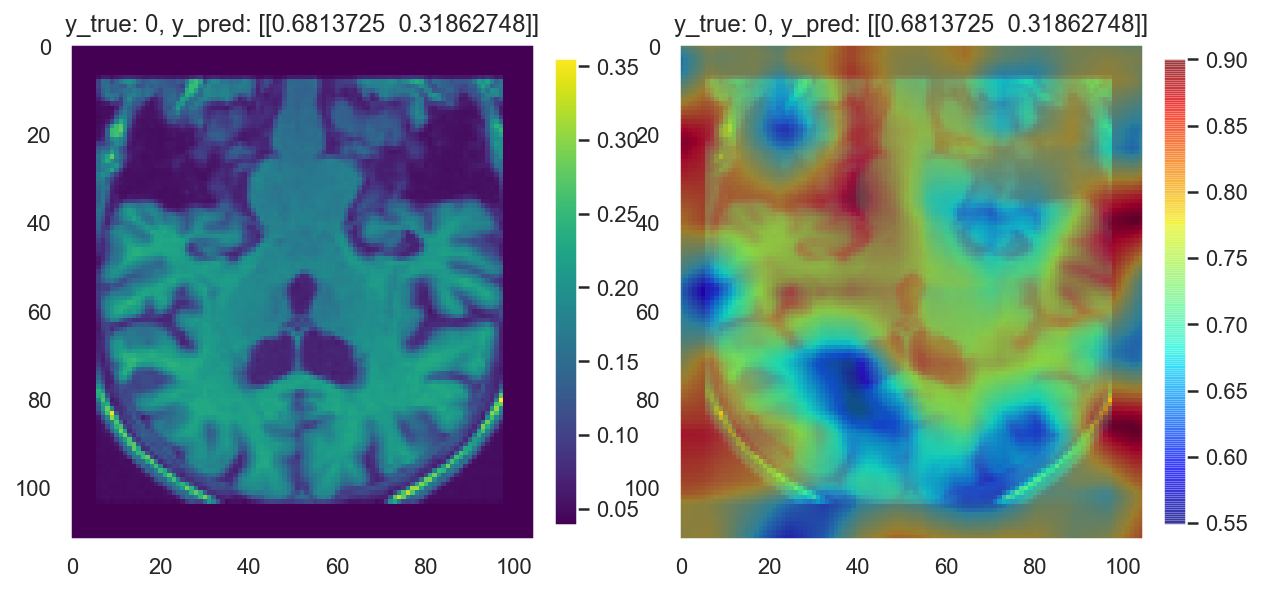

In [46]:
import matplotlib

heatmaps.plot_heatmap_y(image_x, image_y, y_pred, heatmap, 56)

In [43]:
matplotlib.cm.get_cmap()

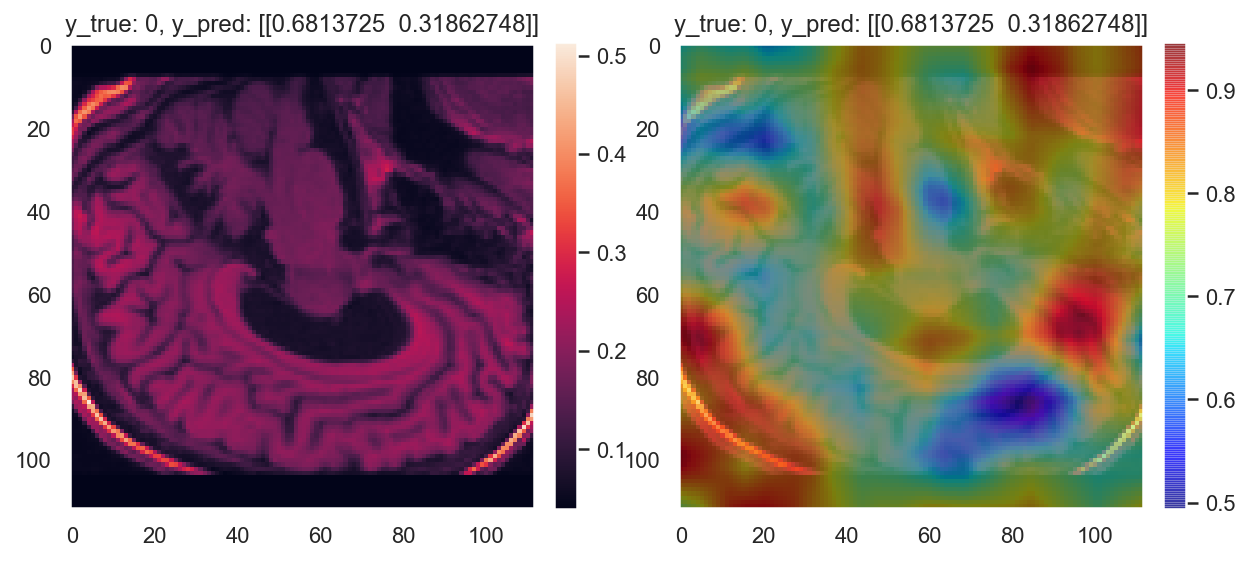

In [28]:
heatmaps.plot_heatmap_x(image_x, image_y, y_pred, heatmap, 56)

### Evaluation

In [17]:
eval_seq_batch_size = batch_size * 4



eval_seq = EvaluationSequence(
    'deletion',
    image_x,
    heatmap,
    step_size=150,
    max_steps=10,
    batch_size=eval_seq_batch_size,
    debug=False,
    log=False
)

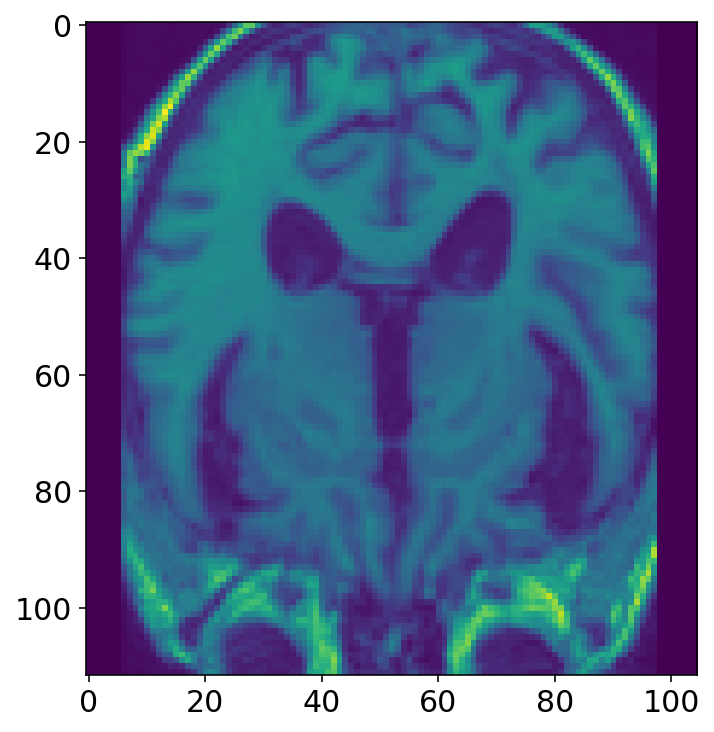

In [21]:
plot_image.plot_image_z(eval_seq.new_image, 56)

In [24]:
plot_evaluation(image_y, y_pred, eval_seq, title='deletion')

ValueError: At least 2 points are needed to compute area under curve, but x.shape = 1